<a href="https://colab.research.google.com/github/pgurazada/gpt-brick-by-brick/blob/main/dev.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Objective

Implement (as faithfully as I can) the GPT algorithms discussed in the DeepMind paper - [Formal Algorithms for Transformers](https://arxiv.org/pdf/2207.09238.pdf).

This notebook borrows inspiration from Karpathy's [Let's build GPT](https://www.youtube.com/watch?v=kCc8FmEb1nY) and code from Gabriel's [implementations](https://gabriel-altay.medium.com/implementing-formal-algorithms-for-transformers-c36d8a5fc03d).

The exposition in this notebook is also close to the one by [Jurafsky](https://web.stanford.edu/~jurafsky/slp3/10.pdf).

# Setup

In [ ]:
!pip install -q tiktoken einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 5.3 MB/s eta 0:00:00


In [ ]:
import tiktoken
import math
import torch
import einops

import torch.nn as nn

from typing import Optional
from torch.nn import functional as F

In [ ]:
torch.manual_seed(42)

# Tokenization and Embedding

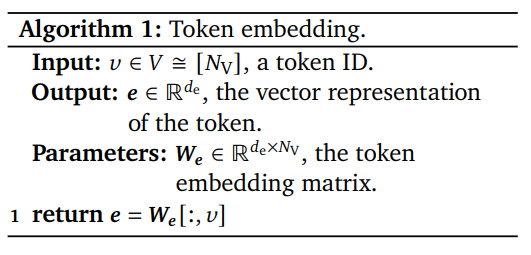

Different encoders have different vocabulary (hence different token IDs).

In [ ]:
enc_gpt2 = tiktoken.get_encoding('gpt2')

In [ ]:
enc_gpt2.n_vocab

50257

In [ ]:
enc_gpt3 = tiktoken.encoding_for_model("gpt-3.5-turbo")

In [ ]:
enc_gpt3.n_vocab

100277

In [ ]:
enc_gpt4 = tiktoken.encoding_for_model("gpt-4")

In [ ]:
enc_gpt4.n_vocab

100277

In [ ]:
enc_gpt2.encode("formal algorithms for transformers")

[687, 282, 16113, 329, 6121, 364]

In [ ]:
enc_gpt2.decode([6121])

' transform'

In [ ]:
enc_gpt4.encode("formal algorithms for transformers")

[630, 278, 26249, 369, 87970]

In [ ]:
enc_gpt2.encode(" ")

[220]

In [ ]:
token_id_start = 4000
token_id_end = 5002

token_list = ''.join(enc_gpt2.decode(range(token_id_start, token_id_end)))

print(token_list)

 pun meantknown notice favoriteaven condition purpose)) organization challeng manufact susp Ac criticunesuclear mervention 80 mist Us Torhttpolf larger advant resear actionsml kept aim,'col benefitsifying actual International vehicle chief efforts League Most wait adult overall speech highly female error effective54 encourwell failed conserv programs trou ahead500vertisementIP Foundpir % crimeander location Iran behaviorazing rare emb caused ship active contribut green acqu reflectvenue firm birth]. clearly emot agencyriage memory98SA SeeacingCC biggest rap basic bandeat suspect Mac 90markistan spreadamskiasyrav Rober demonstrrated absolute places implibrary cards destroy virtvere appearedyanpoint beg temperspeantedears Direct length blogamb integ resourcesacciful spot forced thousands Minister qual Frenchatically generally drink thusILodes appropri Read whom eye college 45irection ensure apparentiders religious minorolic tro Whyributemet primary developed peace skinsteava blue familie

In [ ]:
token_id_start = 1001
token_id_end = 1023

token_list = ''.join(enc_gpt4.decode(range(token_id_start, token_id_end)))

print(token_list)

lementpectash[i use.Fpec adoveceptionengthincludeader                           atusThitleritvoid().(
 off


Now that token ids are in place, we can embed tokens in the input text by chunks of size $l_{\text{max}}$. There are two types of embeddings here - token and position. Let us begin with token embedding.

In [ ]:
class TokenEmbedding(nn.Module):

    """Learned token content embeddings

    Args:
        n_v (int): size of vocabulary
        d_e (int): size of each token embedding

    Input:
        input_ids (tensor) [batch_size, seq_len]: vocabulary input ids

    Output:
        embeddings (tensor) [batch_size, seq_len, d_e]: token embeddings
    """

    def __init__(self, n_v: int, d_e: int):
        super().__init__()
        self.n_v = n_v
        self.d_e = d_e

        self.embedding = nn.Embedding(n_v, d_e)

    def forward(self, input_ids: torch.Tensor):
        return self.embedding(input_ids)

In [ ]:
n_v, d_e = 4, 8

In [ ]:
e = TokenEmbedding(n_v, d_e)

In [ ]:
input_ids = torch.tensor([
    [0, 1, 0],
    [3, 2, 1]
])

In [ ]:
b, s = input_ids.shape

In [ ]:
b, s

(2, 3)

In [ ]:
token_embeddings = e(input_ids)

In [ ]:
token_embeddings

tensor([[[-1.0160,  0.1819,  0.5818,  0.3604, -1.1651,  1.1902,  0.0758,
           0.1418],
         [ 0.0985,  1.2427, -0.1205,  0.7415, -0.8024, -1.6188, -1.6545,
          -0.3522],
         [-1.0160,  0.1819,  0.5818,  0.3604, -1.1651,  1.1902,  0.0758,
           0.1418]],

        [[ 1.0066, -1.3898,  1.8027, -1.3895, -1.1563,  0.1962, -2.4125,
           0.1536],
         [ 1.8787,  0.6604,  2.3090, -1.0126, -0.6605, -0.0616,  2.8377,
          -0.7701],
         [ 0.0985,  1.2427, -0.1205,  0.7415, -0.8024, -1.6188, -1.6545,
          -0.3522]]], grad_fn=<EmbeddingBackward0>)

In [ ]:
input_ids.shape

torch.Size([2, 3])

In [ ]:
token_embeddings.shape

torch.Size([2, 3, 8])

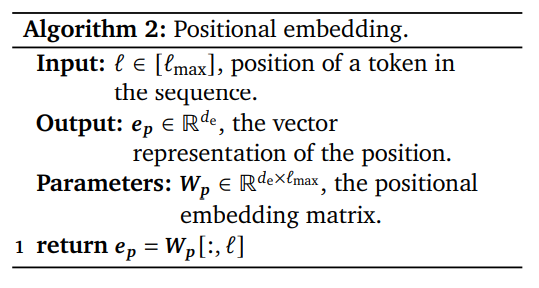

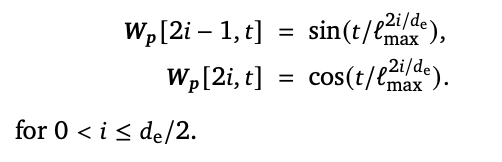

In [ ]:
class PositionalEmedding(nn.Module):

    """Fixed position encodings

    Args:
        l_max (int): max sequence length
        d_e (int): size of each token embedding

    Input:
        input_ids (tensor) [batch_size, seq_len]: vocabulary input ids

    Output:
        embeddings (tensor) [1, seq_len, d_e]: token embeddings

    """

    def __init__(self, l_max: int, d_e: int):
        super().__init__()
        self.l_max = l_max
        self.d_e = d_e

        encodings = torch.zeros(l_max, d_e)                          # [l_max, de]
        position = torch.arange(l_max, dtype=torch.float32)[:, None] # [l_max, 1]
        two_i = torch.arange(0, d_e, 2, dtype=torch.float32)         # [l_max//2]
        div_term = torch.exp(two_i * -(math.log(10000.0) / d_e))
        encodings[:, 0::2] = torch.sin(position * div_term)
        encodings[:, 1::2] = torch.cos(position * div_term)
        encodings = encodings[None, :, :]  # [1, l_max, d_e]
        self.register_buffer("pos_enc", encodings) # <- do not train these encodings

    def forward(self, input_ids: torch.Tensor):
        _, ll = input_ids.shape
        return self.pos_enc[:, :ll, :]

In [ ]:
d_e, l_max = 8, 3

In [ ]:
e_p = PositionalEmedding(l_max, d_e)

In [ ]:
input_ids = torch.tensor([
    [0, 0, 0],
    [0, 0, 0]
])

In [ ]:
b, s = input_ids.shape

In [ ]:
positional_embeddings = e_p(input_ids)

In [ ]:
positional_embeddings

tensor([[[ 0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
           1.0000e+00,  0.0000e+00,  1.0000e+00],
         [ 8.4147e-01,  5.4030e-01,  9.9833e-02,  9.9500e-01,  9.9998e-03,
           9.9995e-01,  1.0000e-03,  1.0000e+00],
         [ 9.0930e-01, -4.1615e-01,  1.9867e-01,  9.8007e-01,  1.9999e-02,
           9.9980e-01,  2.0000e-03,  1.0000e+00]]])

In [ ]:
positional_embeddings.shape

torch.Size([1, 3, 8])

In [ ]:
d_e, l_max = 8, 5

In [ ]:
e_p = PositionalEmedding(l_max, d_e)

In [ ]:
input_ids = torch.tensor([
    [0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0]
])

In [ ]:
b, s = input_ids.shape

In [ ]:
positional_embeddings = e_p(input_ids)

In [ ]:
positional_embeddings

tensor([[[ 0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
           1.0000e+00,  0.0000e+00,  1.0000e+00],
         [ 8.4147e-01,  5.4030e-01,  9.9833e-02,  9.9500e-01,  9.9998e-03,
           9.9995e-01,  1.0000e-03,  1.0000e+00],
         [ 9.0930e-01, -4.1615e-01,  1.9867e-01,  9.8007e-01,  1.9999e-02,
           9.9980e-01,  2.0000e-03,  1.0000e+00],
         [ 1.4112e-01, -9.8999e-01,  2.9552e-01,  9.5534e-01,  2.9995e-02,
           9.9955e-01,  3.0000e-03,  1.0000e+00],
         [-7.5680e-01, -6.5364e-01,  3.8942e-01,  9.2106e-01,  3.9989e-02,
           9.9920e-01,  4.0000e-03,  9.9999e-01]]])

In [ ]:
positional_embeddings.shape

torch.Size([1, 5, 8])

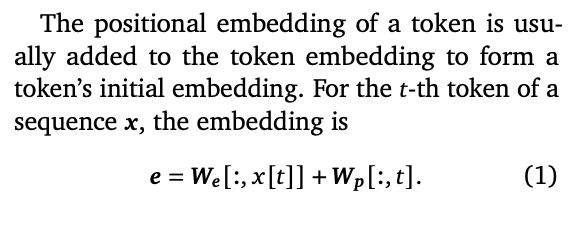

In [ ]:
n_v, d_e, l_max = 4, 8, 3

In [ ]:
input_ids = torch.tensor([
    [0, 1, 2],
    [3, 1, 1]
])

In [ ]:
e = TokenEmbedding(n_v, d_e)
token_embeddings = e(input_ids)

In [ ]:
token_embeddings.shape

torch.Size([2, 3, 8])

In [ ]:
e_p = PositionalEmedding(l_max, d_e)
position_embeddings = e_p(input_ids)

In [ ]:
position_embeddings.shape

torch.Size([1, 3, 8])

In [ ]:
token_position_embeddings = token_embeddings + position_embeddings # positions are broadcasted

In [ ]:
token_position_embeddings

tensor([[[ 0.1549,  0.6739, -0.7646,  1.8233,  0.1482,  0.8770,  0.1102,
           0.4093],
         [ 0.9185,  1.4674, -0.2555,  0.7717, -0.7277,  1.5516, -0.2151,
           2.4853],
         [ 1.4235,  0.1868, -0.7176,  1.7238,  1.0200,  1.6836,  0.8389,
           1.4726]],

        [[-1.0600,  0.3376, -0.9961, -0.4082,  0.5815,  2.5768, -0.6925,
           1.5081],
         [ 0.9185,  1.4674, -0.2555,  0.7717, -0.7277,  1.5516, -0.2151,
           2.4853],
         [ 0.9863,  0.5109, -0.1566,  0.7568, -0.7177,  1.5514, -0.2141,
           2.4853]]], grad_fn=<AddBackward0>)

In [ ]:
token_position_embeddings.shape

torch.Size([2, 3, 8])

# Single-query Attention

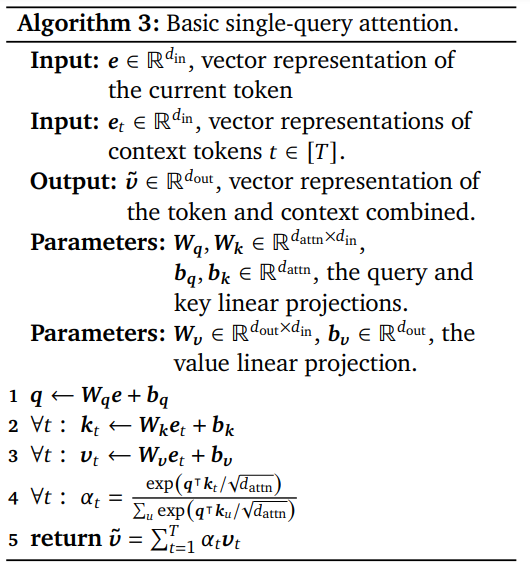

In [ ]:
class SingleQueryAttention(nn.Module):

    """Contextualize single input embedding by attending over context embeddings.

    Args:
        d_x (int): size of primary token embedding
        d_z (int): size of each token emebdding in context sequence
        d_attn (int): query-key projection space has size d_attn
        d_out (int): size of contextualized token embedding
        bias (bool): if true, use bias terms for q,k,v
        do_init (bool): can set to False to leave tensors unintialized

    Input:
        x1 (tensor) [d_x]: single token embedding to be contextualized
        z (tensor) [l_z, d_z]: sequence of context token embeddings
        mask (tensor) [l_z]: attention mask

    Output:
        q (tensor) [d_attn]: query vector for x1
        k (tensor) [l_z, d_attn]: key vectors for z
        v (tensor) [l_z, d_out]: value vectors for z

        score (tensor) [l_z]: score = (q @ k^T) / sqrt(d_attn)
            where mask = 1 else minimum value for score tensor dtype
        attention (tensor) [l_z]: attention weights
            explicitly set to 0 where mask = 0
        vtilde (tensor) [d_out]: contextualized representation of x1

    Attributes:
        w_q (tensor) [d_x, d_attn]: query weight tensor
        w_k (tensor) [d_z, d_attn]: key weight tensor
        w_v (tensor) [d_z, d_out]: value weight tensor

        b_q (tensor) [d_attn]: query bias tensor
        b_k (tensor) [d_attn]: key projection tensor
        b_v (tensor) [d_out]: value projection tensor

    """

    def __init__(
        self,
        d_x: int,
        d_z: int,
        d_attn: int,
        d_out: int,
        do_init: bool = True,
    ):

        super().__init__()
        self.d_x = d_x
        self.d_z = d_z
        self.d_attn = d_attn
        self.d_out = d_out
        self.do_init = do_init

        self.scale = 1 / math.sqrt(d_attn)

        self.w_q = nn.Parameter(torch.empty(d_x, d_attn))
        self.w_k = nn.Parameter(torch.empty(d_z, d_attn))
        self.w_v = nn.Parameter(torch.empty(d_z, d_out))


        self.b_q = nn.Parameter(torch.empty(d_attn))
        self.b_k = nn.Parameter(torch.empty(d_attn))
        self.b_v = nn.Parameter(torch.empty(d_out))

        if self.do_init:
            self.init_weights()


    def init_weights(self):
        nn.init.xavier_normal_(self.w_q)
        nn.init.xavier_normal_(self.w_k)
        nn.init.xavier_normal_(self.w_v)

        nn.init.zeros_(self.b_q)
        nn.init.zeros_(self.b_k)
        nn.init.zeros_(self.b_v)


    def forward(
        self,
        x1: torch.Tensor,
        z: torch.Tensor,
        mask: torch.Tensor,
    ):

        (d_x,) = x1.shape
        (l_z, d_z) = z.shape


        q = x1 @ self.w_q + self.b_q
        k = z @ self.w_k + self.b_k
        v = z @ self.w_v + self.b_v


        score = q @ k.T * self.scale
        score = score.masked_fill(~mask.to(torch.bool), -float("Inf"))
        attention = torch.softmax(score, dim=-1)

        vtilde = attention @ v

        return {
            "q": q,
            "k": k,
            "v": v,
            "score": score,
            "attention": attention,
            "vtilde": vtilde,
        }

In [ ]:
d_x, d_z, d_attn, d_out, l_z = 2, 2, 4, 5, 3

In [ ]:
x1 = torch.randn(d_x)

In [ ]:
x1

tensor([0.1543, 1.3501])

In [ ]:
z = torch.rand(l_z, d_z)

In [ ]:
z

tensor([[0.4729, 0.3870],
        [0.4171, 0.0446],
        [0.9742, 0.2080]])

For GPT we do not want the query to pay attention to the tokens after it. This is where the mask comes to play (it has a dimension $l_z$).

In [ ]:
# This mask forces the query to look only at the first key
mask = torch.tensor([1, 0, 0])

In [ ]:
sqa = SingleQueryAttention(d_x, d_z, d_attn, d_out)

In [ ]:
sqa(x1, z, mask)

{'q': tensor([-0.2434, -0.6276,  0.5250, -0.2388], grad_fn=<AddBackward0>),
 'k': tensor([[-0.9015, -0.1340,  0.3679,  0.5841],
         [-0.4960, -0.0609,  0.3574,  0.3692],
         [-1.2631, -0.1623,  0.8233,  0.9133]], grad_fn=<AddBackward0>),
 'v': tensor([[-0.2884, -0.2761,  0.2047, -0.2280, -0.0962],
         [-0.2970, -0.2130,  0.0149, -0.1119, -0.1708],
         [-0.6787, -0.5081,  0.0928, -0.2925, -0.3688]], grad_fn=<AddBackward0>),
 'score': tensor([0.1786,   -inf,   -inf], grad_fn=<MaskedFillBackward0>),
 'attention': tensor([1., 0., 0.], grad_fn=<SoftmaxBackward0>),
 'vtilde': tensor([-0.2884, -0.2761,  0.2047, -0.2280, -0.0962],
        grad_fn=<SqueezeBackward4>)}

Without the mask

In [ ]:
sqa(x1, z, mask = torch.tensor([1, 1, 1]))

{'q': tensor([-0.2434, -0.6276,  0.5250, -0.2388], grad_fn=<AddBackward0>),
 'k': tensor([[-0.9015, -0.1340,  0.3679,  0.5841],
         [-0.4960, -0.0609,  0.3574,  0.3692],
         [-1.2631, -0.1623,  0.8233,  0.9133]], grad_fn=<AddBackward0>),
 'v': tensor([[-0.2884, -0.2761,  0.2047, -0.2280, -0.0962],
         [-0.2970, -0.2130,  0.0149, -0.1119, -0.1708],
         [-0.6787, -0.5081,  0.0928, -0.2925, -0.3688]], grad_fn=<AddBackward0>),
 'score': tensor([0.1786, 0.1292, 0.3117], grad_fn=<MaskedFillBackward0>),
 'attention': tensor([0.3232, 0.3076, 0.3692], grad_fn=<SoftmaxBackward0>),
 'vtilde': tensor([-0.4351, -0.3424,  0.1050, -0.2161, -0.2198],
        grad_fn=<SqueezeBackward4>)}

In [ ]:
# This mask forces the query to look only at the first two keys
mask = torch.tensor([1, 1, 0])

In [ ]:
sqa = SingleQueryAttention(d_x, d_z, d_attn, d_out)

In [ ]:
sqa(x1, z, mask)

{'q': tensor([ 0.6148,  0.5014, -0.4199,  0.1068], grad_fn=<AddBackward0>),
 'k': tensor([[-0.4591,  0.7361,  0.0515, -0.1219],
         [-0.3817,  0.5254, -0.0722,  0.0365],
         [-0.8997,  1.2704, -0.1275,  0.0349]], grad_fn=<AddBackward0>),
 'v': tensor([[ 0.1906,  0.0237,  0.0172, -0.2788, -0.6574],
         [ 0.2107,  0.0398,  0.0911, -0.2666, -0.5259],
         [ 0.4772,  0.0864,  0.1863, -0.6155, -1.2471]], grad_fn=<AddBackward0>),
 'score': tensor([0.0261, 0.0315,   -inf], grad_fn=<MaskedFillBackward0>),
 'attention': tensor([0.4987, 0.5013, 0.0000], grad_fn=<SoftmaxBackward0>),
 'vtilde': tensor([ 0.2007,  0.0318,  0.0543, -0.2727, -0.5915],
        grad_fn=<SqueezeBackward4>)}

In [ ]:
out = sqa(x1, z, mask)

In [ ]:
out['attention']

tensor([0.4987, 0.5013, 0.0000], grad_fn=<SoftmaxBackward0>)

In [ ]:
x1.shape

torch.Size([2])

In [ ]:
out['vtilde'].shape

torch.Size([5])

# Single-head Attention

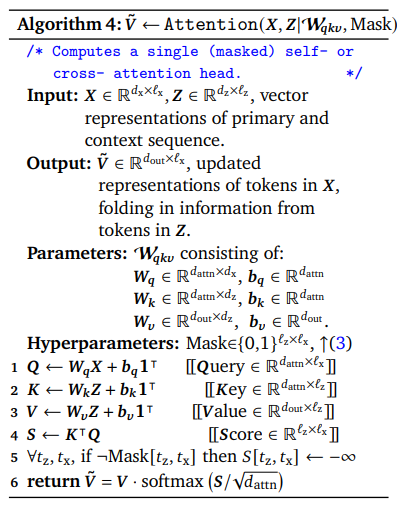

In [ ]:
class SingleHeadAttention(nn.Module):

    """Applies masked self or cross single-head attention.

    Args:
        d_x (int): size of primary token embedding
        d_z (int): size of each token emebdding in context sequence
        d_attn (int): query-key projection space has size d_attn
        d_out (int): size of contextualized token embedding
        bias (bool): if true, use bias terms for q,k,v
        do_init (bool): can set to False to leave tensors unintialized
        dropout_proba (float): dropout probability

    Input:
        x (tensor) [b, l_x, d_x]: token embeddings of primary sequence
        z (tensor) [b, l_z, d_z]: token embeddings of context sequence
        mask (tensor) [b, l_x, l_z]: attention mask (1=attend, 0=dont)

    Output:
        q (tensor) [b, l_x, d_attn]: query vectors for x
        k (tensor) [b, l_z, d_attn]: key vectors for z
        v (tensor) [b, l_z, d_out]: value vectors for z

        score (tensor) [b, l_x, l_z]: (q @ k^T) / sqrt(d_attn) for each batch
            where mask = 1 else minimum value for score tensor dtype
        attention (tensor) [b, l_x, l_z]: attention weights
            explicitly set to 0 where mask = 0
        vtilde (tensor) [b, l_x, d_out]: contextualized representation of x

    Attributes:
        w_q (tensor): [d_x, d_attn] query weight tensor
        w_k (tensor): [d_z, d_attn] key weight tensor
        w_v (tensor): [d_z, d_out] value weight tensor

        b_q (tensor): [d_attn] query bias tensor
        b_k (tensor): [d_attn] key projection tensor
        b_v (tensor): [d_out] value projection tensor

    """

    def __init__(
        self,
        d_x: int,
        d_z: int,
        d_attn: int,
        d_out: int,
        do_init: bool = True,
        dropout_proba: float = 0.1,
    ):

        super().__init__()
        self.d_x = d_x
        self.d_z = d_z
        self.d_out = d_out
        self.d_attn = d_attn
        self.do_init = do_init
        self.dropout_proba = dropout_proba
        self.scale = 1 / math.sqrt(d_attn)

        self.w_q = nn.Parameter(torch.empty(d_x, d_attn))
        self.w_k = nn.Parameter(torch.empty(d_z, d_attn))
        self.w_v = nn.Parameter(torch.empty(d_z, d_out))
        self.drop = nn.Dropout(dropout_proba)

        self.b_q = nn.Parameter(torch.empty(d_attn))
        self.b_k = nn.Parameter(torch.empty(d_attn))
        self.b_v = nn.Parameter(torch.empty(d_out))

        if self.do_init:
            self.init_weights()


    def init_weights(self):
        nn.init.xavier_normal_(self.w_q)
        nn.init.xavier_normal_(self.w_k)
        nn.init.xavier_normal_(self.w_v)

        nn.init.zeros_(self.b_q)
        nn.init.zeros_(self.b_k)
        nn.init.zeros_(self.b_v)


    def forward(
        self,
        x: torch.Tensor,
        z: torch.Tensor,
        mask: torch.Tensor,
    ):

        # this is batch matrix multiplication
        einsum_str = "b i k, k j -> b i j"

        q = torch.einsum(einsum_str, x, self.w_q) + self.b_q
        k = torch.einsum(einsum_str, z, self.w_k) + self.b_k
        v = torch.einsum(einsum_str, z, self.w_v) + self.b_v

        # this is batch matrix multiplication with k transposed
        score = torch.einsum("b i k, b j k -> b i j", q, k) * self.scale
        score = score.masked_fill(~mask.to(torch.bool), -float("Inf"))

        attention = torch.softmax(score, dim=-1)

        # apply dropout to attention tensor
        attention = self.drop(attention)

        vtilde = attention @ v

        return {
            "q": q,
            "k": k,
            "v": v,
            "score": score,
            "attention": attention,
            "vtilde": vtilde,
        }

To illustrate how the above single-head attention algorithm is used in GPT as self-attention, consider the following sequences:

Sequence 1: `<s> formal algorithms for transformers <\s>`

Sequence 2: `<s> normal algorithms for transformers <\s>`

This is a batch of 2 sequences that is converted to multiple sequences like so.

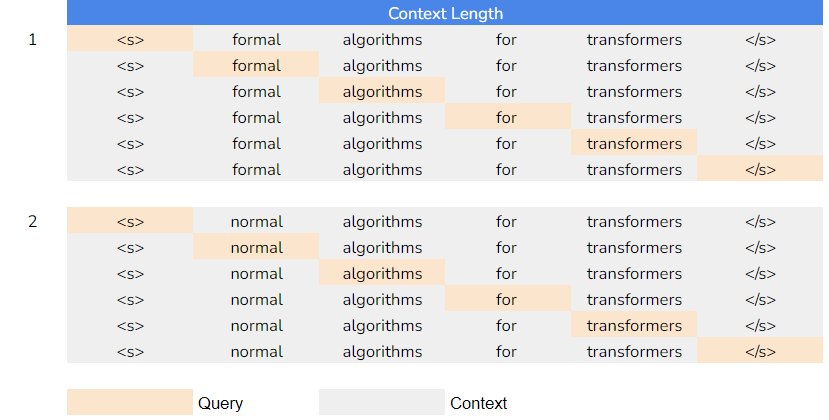

In [ ]:
b = 2 # Batch of 2 sequences
l_x = 6 # 6 query tokens
d_x = 2 # each query 2-dimensional

l_z = 6 # 6 context tokens each 2-dimensional; context repeats for GPT
d_z = 2 # context dimension

d_attn = 4
d_out = 3

In [ ]:
x = torch.rand(b, l_x, d_x)
z = torch.rand(b, l_z, d_z)

In [ ]:
x.shape, z.shape

(torch.Size([2, 6, 2]), torch.Size([2, 6, 2]))

In this sequence, the same 6 tokens always act as the context for the 6 different tokens that act as queries.

`einsum` is a neat way to specify matrix operations on operands in text allowing the library to execute these ops. In this case we are using `einsum` to do matric ops on batches.

In [ ]:
a = torch.arange(6).reshape(2, 3)
print(a)
# transpose of a
torch.einsum('ij->ji', a)

tensor([[0, 1, 2],
        [3, 4, 5]])


tensor([[0, 3],
        [1, 4],
        [2, 5]])

In [ ]:
print(a)
# Sum all the entries of a (summation is implicitly done)
torch.einsum('ij->', a)

tensor([[0, 1, 2],
        [3, 4, 5]])


tensor(15)

In [ ]:
print(a)
# Column sum (i.e., only j is left)
torch.einsum('ij->j', a)

tensor([[0, 1, 2],
        [3, 4, 5]])


tensor([3, 5, 7])

In [ ]:
print(a)
# Row sum
torch.einsum('ij->i', a)

tensor([[0, 1, 2],
        [3, 4, 5]])


tensor([ 3, 12])

In [ ]:
# Matrix - vector multiply
a = torch.arange(6).reshape(2, 3)
b = torch.arange(3)

print(a)
print(b)
torch.einsum('ik,k->i', a, b) # b is parsed as a column

tensor([[0, 1, 2],
        [3, 4, 5]])
tensor([0, 1, 2])


tensor([ 5, 14])

In [ ]:
# Matrix Multiplication
a = torch.arange(6).reshape(2, 3)
b = torch.arange(15).reshape(3, 5)
print(a)
print(b)
torch.einsum('ik,kj->ij', a, b)

tensor([[0, 1, 2],
        [3, 4, 5]])
tensor([[ 0,  1,  2,  3,  4],
        [ 5,  6,  7,  8,  9],
        [10, 11, 12, 13, 14]])


tensor([[ 25,  28,  31,  34,  37],
        [ 70,  82,  94, 106, 118]])

In [ ]:
# Matrix dot product
a = torch.arange(6).reshape(2, 3)
b = torch.arange(6,12).reshape(2, 3)
torch.einsum('ij,ij->', a, b)

tensor(145)

In [ ]:
# Batch matrix multiply
# batch size of 3
a = torch.randn(3, 2, 5)
b = torch.randn(3, 5, 3)

torch.einsum('b i k, b k j -> b i j', a, b)

tensor([[[-2.5841, -1.5397, -0.5658],
         [-0.6854,  1.8579, -1.0561]],

        [[-3.2020,  0.3751, -2.1895],
         [-1.0746, -3.1390,  0.8517]],

        [[-0.1964,  1.6691, -4.4416],
         [ 2.0682,  0.6396, -3.9263]]])

In [ ]:
# Batch matrix multiply for Q (K, V are similar)

b, l_x, d_x = 2, 6, 2
d_attn = 4

x = torch.randn(b, l_x, d_x)
W_q = torch.randn(d_x, d_attn)

torch.einsum('b i k, k j -> b i j', x, W_q)

tensor([[[ 8.5527e-01,  2.3445e+00, -8.1034e-01,  1.1104e+00],
         [-1.9206e-01,  2.2050e+00, -5.4643e-01,  1.1844e+00],
         [-9.1332e-01, -7.8181e-01,  4.0619e-01, -2.8205e-01],
         [ 1.1259e-01,  1.6864e-01, -6.9342e-02,  7.2698e-02],
         [-7.4229e-01,  2.1252e+00, -4.0603e-01,  1.2198e+00],
         [ 2.5044e-01, -3.7273e+00,  9.3972e-01, -1.9916e+00]],

        [[ 5.8454e-01, -2.8424e+00,  6.3142e-01, -1.5740e+00],
         [ 6.9568e-01, -5.7896e-01,  3.7952e-03, -4.0162e-01],
         [-7.3244e-01, -4.8359e+00,  1.4481e+00, -2.4354e+00],
         [-7.6686e-01,  4.4247e+00, -1.0139e+00,  2.4301e+00],
         [ 6.9673e-01, -2.8329e-01, -7.5276e-02, -2.4657e-01],
         [-5.6355e-01,  1.2864e+00, -2.2103e-01,  7.5435e-01]]])

In [ ]:
# Batch matrix multiply for Q(KTranspose)
b, l_x, d_attn = 2, 6, 4

Q = torch.randn(b, l_x, d_attn)
K = torch.randn(b, l_x, d_attn)

torch.einsum('b i k, b j k -> b i j', Q, K)

tensor([[[ 1.4634, -0.1184, -0.7431,  1.4276, -2.1948, -0.3333],
         [ 0.1743, -0.3679,  2.9651, -2.0430, -0.7337, -0.8992],
         [-0.4850, -0.2883, -0.0441, -3.6116, -4.2134, -1.9912],
         [ 0.0396, -0.3081,  0.4149, -0.2982, -0.5105, -0.2788],
         [ 0.3670, -0.9495,  4.0409,  0.0651,  1.9047,  0.1481],
         [-1.0850,  0.9104, -2.9550, -0.1968,  0.5028,  0.4548]],

        [[ 0.0865,  2.3134, -0.2601,  0.6342, -1.7875, -0.7420],
         [-0.3659, -2.2404, -0.6369, -2.2218, -1.3724, -0.8164],
         [-0.0737, -0.2936, -0.9775, -0.5009,  1.4307, -0.7954],
         [ 0.4435,  4.0903,  1.3927,  4.4116,  5.7740,  2.8657],
         [-0.7515,  7.0213, -0.8165,  0.2700, -4.2933, -0.7553],
         [-0.1518,  2.0378,  1.3961,  0.5301, -4.0197,  1.0563]]])

In [ ]:
Q.shape, K.shape

(torch.Size([2, 6, 4]), torch.Size([2, 6, 4]))

Now let us look at the role of masking in the context of these two sequences.

In [ ]:
b = 2 # Batch of 2 sequences
l_x = 6 # 6 query tokens each 2-dimensional
d_x = 2 # query dimension

l_z = 6 # 6 context tokens (including the query itself) each 2-dimensional
d_z = 2 # context dimension

d_out = 3
d_attn = 4

In [ ]:
bidirectional_mask = torch.ones(b, l_x, l_z)

In [ ]:
bidirectional_mask

tensor([[[1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1.]],

        [[1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1.]]])

In [ ]:
unidirectional_mask = torch.tril(bidirectional_mask)

In [ ]:
unidirectional_mask

tensor([[[1., 0., 0., 0., 0., 0.],
         [1., 1., 0., 0., 0., 0.],
         [1., 1., 1., 0., 0., 0.],
         [1., 1., 1., 1., 0., 0.],
         [1., 1., 1., 1., 1., 0.],
         [1., 1., 1., 1., 1., 1.]],

        [[1., 0., 0., 0., 0., 0.],
         [1., 1., 0., 0., 0., 0.],
         [1., 1., 1., 0., 0., 0.],
         [1., 1., 1., 1., 0., 0.],
         [1., 1., 1., 1., 1., 0.],
         [1., 1., 1., 1., 1., 1.]]])

In [ ]:
sha = SingleHeadAttention(d_x, d_z, d_attn, d_out)

In [ ]:
out = sha(x, z, unidirectional_mask)

Using a unidirectional mask forces a query to look only at the tokens before it.

In [ ]:
out['attention']

tensor([[[1.1111, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.5616, 0.5495, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.3594, 0.3901, 0.3616, 0.0000, 0.0000, 0.0000],
         [0.2790, 0.2759, 0.2802, 0.2760, 0.0000, 0.0000],
         [0.2276, 0.2324, 0.2757, 0.0000, 0.2201, 0.0000],
         [0.1686, 0.1759, 0.1289, 0.2921, 0.1709, 0.1747]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.5347, 0.5764, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.4332, 0.3228, 0.3551, 0.0000, 0.0000, 0.0000],
         [0.2709, 0.2897, 0.2805, 0.2700, 0.0000, 0.0000],
         [0.2079, 0.0000, 0.2217, 0.2092, 0.0000, 0.0000],
         [0.1970, 0.0000, 0.1922, 0.1962, 0.1498, 0.1845]]],
       grad_fn=<MulBackward0>)

There were 6 tokens in the sentence. Each token becomes a query that was an "out-of-context" 2 dimensional vector and gets "contextualized" as a 3 dimensional vector as it goes through the attention.

In [ ]:
out

{'q': tensor([[[ 2.3798e-01,  8.1546e-01, -9.1990e-03,  2.5441e-01],
          [ 9.6085e-01,  5.3863e-01, -6.0672e-01,  2.0181e-01],
          [ 3.8524e-01, -4.1584e-01, -3.7393e-01, -1.0845e-01],
          [-2.0658e-02,  7.0357e-02,  2.9991e-02,  2.0220e-02],
          [ 1.3382e+00,  3.9147e-01, -9.1917e-01,  1.7356e-01],
          [-1.5693e+00, -9.2747e-01,  9.8102e-01, -3.4392e-01]],
 
         [[-1.4878e+00, -6.1710e-01,  9.8432e-01, -2.4747e-01],
          [-7.2955e-01,  6.4192e-03,  5.4658e-01, -2.8728e-02],
          [-1.2540e+00, -1.4456e+00,  6.3818e-01, -4.8597e-01],
          [ 2.2102e+00,  9.9342e-01, -1.4464e+00,  3.9062e-01],
          [-6.2054e-01,  8.4784e-02,  4.8131e-01, -6.6017e-04],
          [ 8.9449e-01,  2.1077e-01, -6.2493e-01,  1.0076e-01]]],
        grad_fn=<AddBackward0>),
 'k': tensor([[[ 0.0042,  0.2902,  0.6107,  0.6347],
          [-0.0540,  0.1128,  0.3667,  0.4346],
          [ 0.2420,  0.5464,  0.6048,  0.4031],
          [-0.4872, -0.2636,  0.5701,  1

In [ ]:
x.shape

torch.Size([2, 6, 2])

In [ ]:
out['vtilde'].shape

torch.Size([2, 6, 3])

# Multi-head Attention

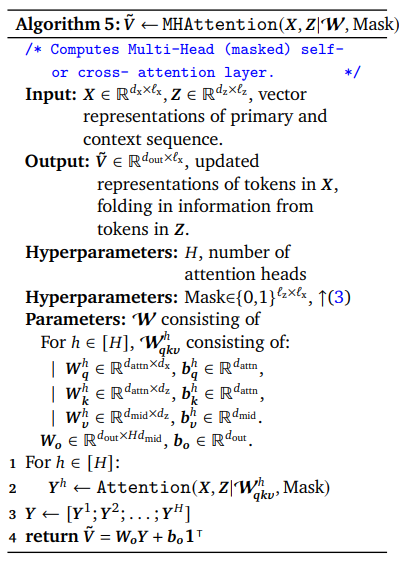

In [ ]:
class MultiHeadAttention(nn.Module):

    """Applies masked self or cross multi-head attention.

    Args:
        d_x (int): size of each token embedding in primary sequence
        d_z (int): size of each token emebdding in context sequence
        d_attn (int): query-key projection space has size d_attn
        d_mid (int): value projection space has size d_mid
        H (int): number of attention heads
        d_out (int): size of each embedding in output sequence
        do_init (bool): can set to False to leave tensors unintialized
        dropout_proba (float): dropout probability

    Input:
        x (tensor) [b, l_x, d_x]: token embeddings of primary sequence
        z (tensor) [b, l_z, d_z]: token embeddings of context sequence
        mask (tensor) [b, l_x, l_z]: attention mask (1=attend, 0=dont)

    Output:
        q (tensor) [b, H, l_x, d_attn]: query vectors for x
        k (tensor) [b, H, l_z, d_attn]: key vectors for z
        v (tensor) [b, H, l_z, d_mid]: value vectors for z

        score (tensor) [b, H, l_x, l_z]: (q @ k^T) / sqrt(d_attn)
            for each batch and head where mask = 1
            else minimum value for score tensor dtype
        attention (tensor) [b, H, l_x, l_z]: attention weights
            explicitly set to 0 where mask = 0
        yh (tensor) [b, H, l_x, d_mid]: contextualized x from each head
        y (tensor): [b, l_x, H * d_mid] rearrangement of yh
        vtilde (tensor): [b, l_x, d_out] contextualized representation of x

    Attributes:
        w_q (tensor) [H, d_x, d_attn] query weight tensor
        w_k (tensor) [H, d_z, d_attn] key weight tensor
        w_v (tensor) [H, d_z, d_mid] value weight tensor
        w_o (tensor) [H * d_mid, d_out] output weight tensor

        b_q (tensor) [H, d_attn]: query bias tensor
        b_k (tensor) [H, d_attn]: key bias tensor
        b_v (tensor) [H, d_mid]: value bias tensor
        b_o (tensor) [d_out]: output bias tensor

    """

    def __init__(
        self,
        d_x: int,
        d_z: int,
        d_attn: int,
        d_mid: int,
        H: int,
        d_out: int,
        do_init: bool = True,
        dropout_proba: float = 0.1,
    ):

        super().__init__()
        self.d_x = d_x
        self.d_z = d_z
        self.d_attn = d_attn
        self.d_mid = d_mid
        self.H = H
        self.d_out = d_out
        self.do_init = do_init
        self.dropout_proba = dropout_proba
        self.scale = 1 / math.sqrt(d_attn)

        self.w_q = nn.Parameter(torch.empty(H, d_x, d_attn))
        self.w_k = nn.Parameter(torch.empty(H, d_z, d_attn))
        self.w_v = nn.Parameter(torch.empty(H, d_z, d_mid))
        self.w_o = nn.Parameter(torch.empty(H * d_mid, d_out))
        self.drop = nn.Dropout(dropout_proba)

        self.b_q = nn.Parameter(torch.empty(H, d_attn))
        self.b_k = nn.Parameter(torch.empty(H, d_attn))
        self.b_v = nn.Parameter(torch.empty(H, d_mid))
        self.b_o = nn.Parameter(torch.empty(d_out))

        if self.do_init:
            self.init_weights()


    def init_weights(self):
        nn.init.xavier_normal_(self.w_q)
        nn.init.xavier_normal_(self.w_k)
        nn.init.xavier_normal_(self.w_v)
        nn.init.xavier_normal_(self.w_o)

        nn.init.zeros_(self.b_q)
        nn.init.zeros_(self.b_k)
        nn.init.zeros_(self.b_v)
        nn.init.zeros_(self.b_o)

    def forward(
        self,
        x: torch.Tensor,
        z: torch.Tensor,
        mask: torch.Tensor,
    ):

        # batch matrix multiplication for each batch and head
        einsum_str = "b i k, h k j -> b h i j"

        q = torch.einsum(einsum_str, x, self.w_q) + self.b_q[None, :, None, :]
        k = torch.einsum(einsum_str, z, self.w_k) + self.b_k[None, :, None, :]
        v = torch.einsum(einsum_str, z, self.w_v) + self.b_v[None, :, None, :]

        # this is batch matrix multiplication with k transposed
        score = torch.einsum("b h i k, b h j k -> b h i j", q, k) * self.scale

        # create [b, 1, l_x, l_z] which is broadcastable to [b, h, l_x, l_z]
        emask = mask[:, None, :, :]
        bmask = emask.to(torch.bool)

        score = score.masked_fill(~bmask, -float("Inf"))

        attention = torch.softmax(score, dim=-1)

        # apply dropout to attention tensor
        attention = self.drop(attention)

        # yh [b, h, l_x, d_mid]
        yh = attention @ v

        # y [b, l_x, h * d_mid]
        y = einops.rearrange(yh, "b h l d -> b l (h d)")

        vtilde = torch.einsum("b l k, k d -> b l d", y, self.w_o) + self.b_o

        return {
            "q": q,
            "k": k,
            "v": v,
            "score": score,
            "yh": yh,
            "y": y,
            "attention": attention,
            "vtilde": vtilde,
        }

In [ ]:
b = 2 # Batch of 2 sequences
l_x = 6 # 6 query tokens each 2-dimensional
d_x = 2 # query dimension

l_z = 6 # 6 context tokens (including the query itself) each 2-dimensional
d_z = 2 # context dimension

d_out = 3
d_attn = 4

d_mid = 6
H = 2

In [ ]:
b_q  = torch.empty(H, d_attn)
nn.init.zeros_(b_q)
print(b_q)
b_q[None, :, None, :]

tensor([[0., 0., 0., 0.],
        [0., 0., 0., 0.]])


tensor([[[[0., 0., 0., 0.]],

         [[0., 0., 0., 0.]]]])

In [ ]:
x = torch.rand(b, l_x, d_x)
z = torch.rand(b, l_z, d_z)

bidirectional_mask = torch.ones(b, l_x, l_z)
unidirectional_mask = torch.tril(bidirectional_mask)

In [ ]:
mha = MultiHeadAttention(d_x, d_z, d_attn, d_mid, H, d_out)
out = mha(x, z, unidirectional_mask)

In [ ]:
out

{'q': tensor([[[[ 0.0037,  0.0245, -0.3133, -0.1887],
           [-0.1216,  0.6327,  0.0609, -0.5282],
           [-0.0171,  0.1407, -0.3627, -0.3181],
           [-0.0792,  0.3949,  0.1615, -0.2639],
           [-0.1301,  0.6562,  0.2123, -0.4684],
           [-0.0586,  0.3041,  0.0359, -0.2503]],
 
          [[ 0.0558, -0.0799,  0.0121, -0.0695],
           [-0.3017, -0.3237,  0.2617, -0.0853],
           [ 0.0133, -0.1523,  0.0606, -0.0979],
           [-0.2147, -0.1757,  0.1626, -0.0273],
           [-0.3447, -0.3039,  0.2705, -0.0572],
           [-0.1464, -0.1541,  0.1257, -0.0396]]],
 
 
         [[[-0.0648,  0.3475, -0.0427, -0.3307],
           [-0.0181,  0.1548, -0.4250, -0.3637],
           [-0.0836,  0.4679, -0.1928, -0.5174],
           [ 0.0116,  0.0032, -0.4588, -0.2474],
           [-0.0885,  0.4651,  0.0103, -0.4067],
           [-0.0891,  0.4666,  0.0236, -0.4010]],
 
          [[-0.1494, -0.1940,  0.1442, -0.0628],
           [ 0.0202, -0.1731,  0.0668, -0.1131],
   

In [ ]:
x.shape

torch.Size([2, 6, 2])

In [ ]:
out['vtilde'].shape

torch.Size([2, 6, 3])

Number of parameters in 2-headed masked self-attention.

In [ ]:
sum(p.numel() for p in mha.parameters())

123

# Unembedding

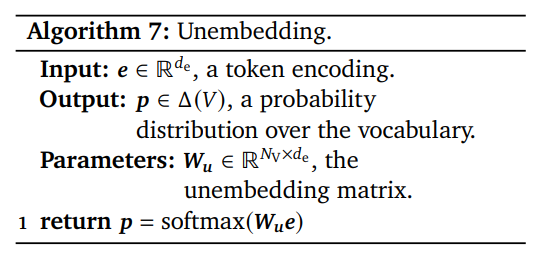

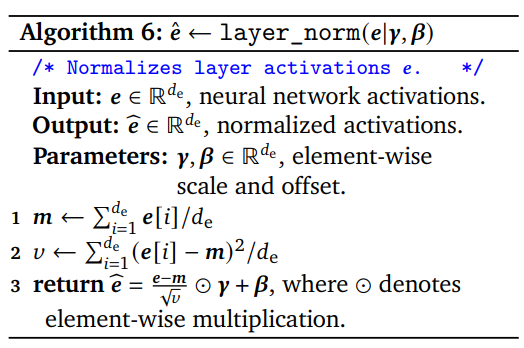

In [ ]:
class Unembedding(nn.Module):
    """Project a masked language modeling head back to the vocabulary space

    Args:
        d_out (int): size of each token hidden state
        n_v (int): size of vocabulary

    Input:
        x (tensor) [b, l_x, d_out]: token hidden states

    Output:
        out (tensor) [b, l_x, n_v]: softmax of vocab logits
    """

    def __init__(self, d_out: int, n_v: int):
        super().__init__()
        self.d_out = d_out
        self.n_v = n_v

        self.linear_w_f = nn.Sequential(nn.Linear(d_out, d_out), nn.GELU())
        self.norm = nn.LayerNorm(d_out)
        self.linear_w_u = nn.Linear(d_out, n_v)

    def forward(self, x):
        x = self.linear_w_f(x)
        x = self.norm(x)
        x = self.linear_w_u(x)
        x = torch.softmax(x, dim=-1) # note: softmax is numerically more stable in the loss function
        return x

In [ ]:
b = 2 # Batch of 2 sequences
d_out = 3 # dimension of multi-head attention output that we want to project back to the vocabulary space
l_x = 6 # length of query tokens in each batch

n_v = 26 # size of vocabulary

In [ ]:
output_mha = torch.randn(b, l_x, d_out)

In [ ]:
unemb = Unembedding(d_out, n_v)

In [ ]:
softmaxes = unemb(output_mha)

In [ ]:
softmaxes.shape

torch.Size([2, 6, 26])

# Transformer Architectures

In [1]:
!pip install -q transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 49.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 30.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 93.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 72.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 27.4 MB/s eta 0:00:00


## Inference

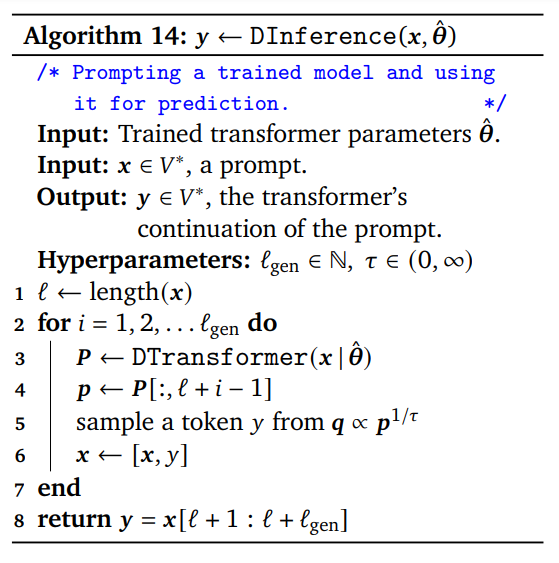

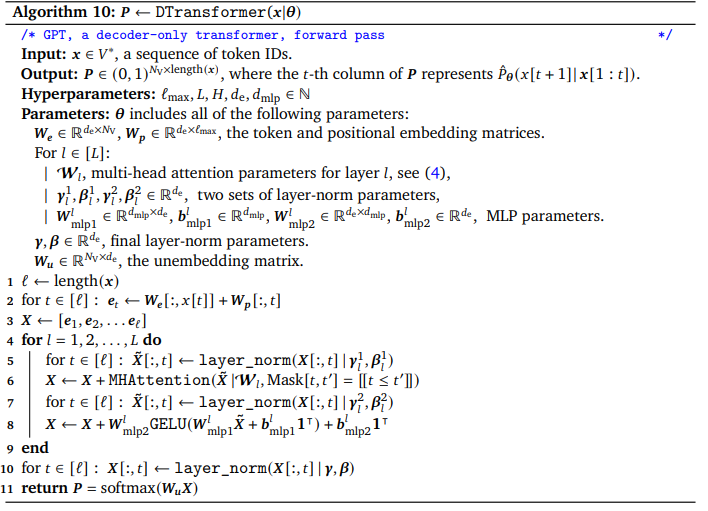

In [2]:
import torch

from transformers import (
    AutoTokenizer, AutoModelForCausalLM, GenerationConfig,
    DataCollatorForLanguageModeling
)

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
checkpoint = "gpt2"

In [5]:
tokenizer = AutoTokenizer.from_pretrained(
    checkpoint,
    max_length=9,
    padding_side="left"
)

In [6]:
tokenizer.pad_token = tokenizer.eos_token

In [7]:
text_batch = [
    "formal algorithms for transformers",
    "normal algorithms for transformers"
]

In [8]:
inputs = tokenizer(
    text_batch,
    max_length=9,
    padding='max_length',
    return_tensors='pt'
)

In [9]:
inputs

{'input_ids': tensor([[50256, 50256, 50256,   687,   282, 16113,   329,  6121,   364],
        [50256, 50256, 50256, 50256, 11265, 16113,   329,  6121,   364]]), 'attention_mask': tensor([[0, 0, 0, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 1, 1, 1, 1, 1]])}

In [10]:
for key in inputs:
    print(f"{key} shape: {inputs[key].shape}")

input_ids shape: torch.Size([2, 9])
attention_mask shape: torch.Size([2, 9])


In [11]:
model = AutoModelForCausalLM.from_pretrained(
    checkpoint,
    pad_token_id=tokenizer.eos_token_id
)

In [12]:
model = model.to(device)

In [13]:
model

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [15]:
outputs = model(**inputs)

In [16]:
outputs.logits.shape

torch.Size([2, 9, 50257])

In [29]:
# output for the tokens of the first sample of the batch
for _ in range(9):
    output_token_id = torch.argmax(outputs.logits[0][_])
    print(tokenizer.decode(output_token_id))

,
form
form
form
form
forms
 for
 transform
 transform


In [30]:
# output for the tokens of the second sample of the batch
for _ in range(9):
    output_token_id = torch.argmax(outputs.logits[1][_])
    print(tokenizer.decode(output_token_id))

,
normal
normal
"
normal
 normal
 normal
 transform
 transforms


To generate text, we need to recursively pass in the text input with a sampling strategy.

Greedy search always chooses the token with the highest probability.

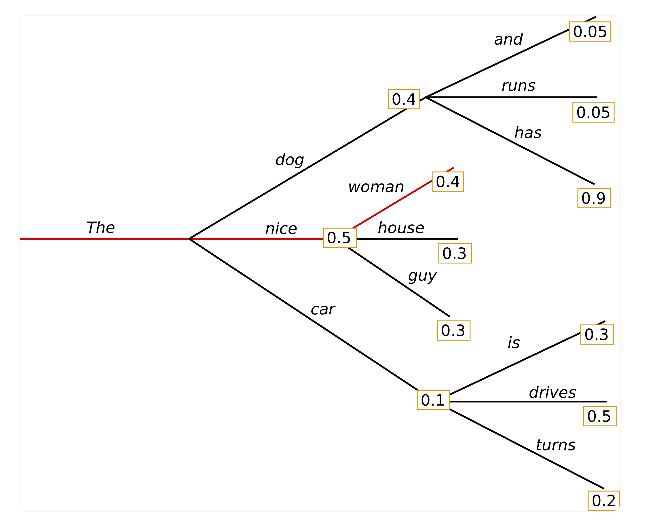

[Source](https://huggingface.co/blog/how-to-generate)

In [ ]:
greedy_config = GenerationConfig(
    num_beams=1,
    do_sample=False,
    pad_token_id=model.config.pad_token_id
)

In [ ]:
greedy_output = model.generate(
    **inputs,
    max_new_tokens=5,
    generation_config=greedy_config
)

In [ ]:
tokenizer.batch_decode(greedy_output, skip_special_tokens=True)

['formal algorithms for transformers and transformers for the',
 'normal algorithms for transformers and transformers with a']

In [ ]:
tokenizer.batch_decode(greedy_output, skip_special_tokens=False)

['<|endoftext|><|endoftext|><|endoftext|>formal algorithms for transformers and transformers for the',
 '<|endoftext|><|endoftext|><|endoftext|><|endoftext|>normal algorithms for transformers and transformers with a']

Multinomial strategy samples the token using the probability distribution.

In [ ]:
multinomial_config = GenerationConfig(
    num_beams=1,
    do_sample=True,
    pad_token_id=model.config.pad_token_id
)

In [ ]:
multinomial_output = model.generate(
    **inputs,
    max_new_tokens=5,
    generation_config=multinomial_config
)

In [ ]:
tokenizer.batch_decode(multinomial_output, skip_special_tokens=True)

['formal algorithms for transformers, transformers for vectors',
 'normal algorithms for transformers and transformers with respect']

Beam search spawns multiple paths and chooses the path with the overall highest probability for the path.

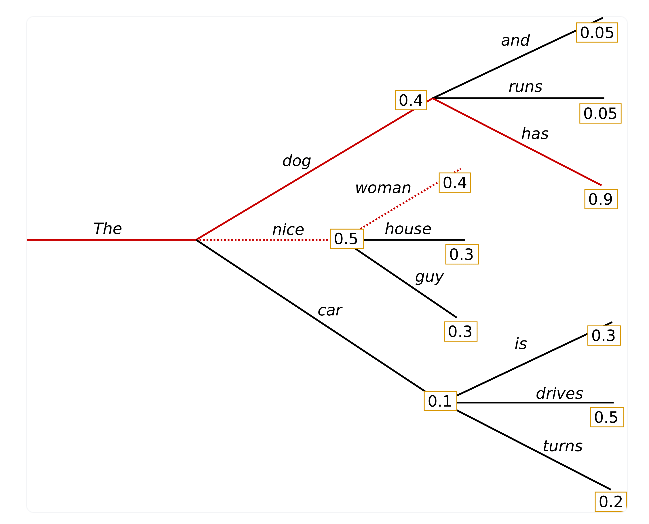

In [ ]:
beam_config = GenerationConfig(
    num_beams=4,
    beam_size=3,
    do_sample=True, # <- this is beam search with multinomial sampling
    pad_token_id=model.config.pad_token_id
)

In [ ]:
beam_search_output = model.generate(
    **inputs,
    max_new_tokens=5,
    generation_config=beam_config
)

In [ ]:
tokenizer.batch_decode(beam_search_output, skip_special_tokens=True)

['formal algorithms for transformers and transformers.\n',
 'normal algorithms for transformers and transformers.\n']

In [ ]:
beam_config = GenerationConfig(
    num_beams=4,
    do_sample=False, # <- this is beam search without multinomial sampling
    pad_token_id=model.config.pad_token_id
)

In [ ]:
beam_search_output = model.generate(
    **inputs,
    max_new_tokens=5,
    generation_config=beam_config
)

In [ ]:
tokenizer.batch_decode(beam_search_output, skip_special_tokens=True)

['formal algorithms for transformers.\n\nIn the',
 'normal algorithms for transformers.\n\nIn the']

## Training

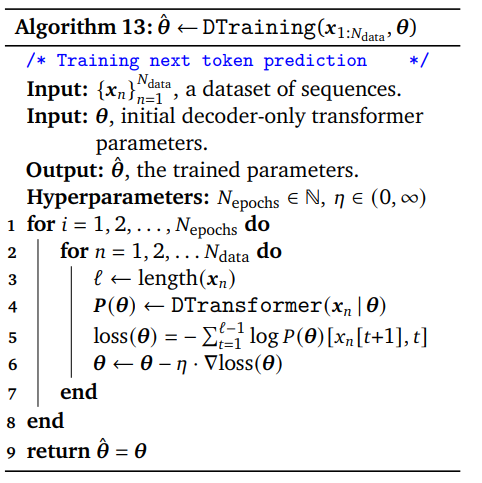

In [1]:
!pip install -q transformers[torch] datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 57.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 55.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 33.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 92.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 90.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.1/258.1 kB 32.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 22.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 37.2 MB/s eta 0:00:00


In [2]:
import torch

from datasets import load_dataset

from transformers import (
    AutoTokenizer, AutoModelForCausalLM, DataCollatorForLanguageModeling,
    Trainer, TrainingArguments, AdamW,
    GenerationConfig
)

The crux of the training pipeline.

In [3]:
tokenizer = AutoTokenizer.from_pretrained("distilgpt2")
model = AutoModelForCausalLM.from_pretrained("distilgpt2")

In [4]:
# the input sequence
input_sequence = tokenizer.encode('formal algorithms for', return_tensors='pt')
# the output label (self-supervised)
target_sequence = tokenizer.encode('transformers.', return_tensors='pt')
# forward pass:
outputs = model(input_sequence)
# even though we do not want a label for each token, the transformer still
# generates logits for each token
print(outputs.logits.size())

torch.Size([1, 4, 50257])


In [6]:
target_sequence[0][0]

tensor(35636)

In [7]:
outputs.logits[0, -1].view(1, -1)

tensor([[-59.9089, -59.4575, -62.6742,  ..., -61.6179, -63.9625, -57.7919]],
       grad_fn=<ViewBackward0>)

In [8]:
# we want to extract only the last logit, and covert it into a vector of logits
lasty = outputs.logits[0, -1].view(1, -1)

# Negative log likelihood loss as mentioned in algorithm 13
loss_function = torch.nn.NLLLoss(reduction="sum")

# Optimizer for gradient descent
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

# To illustrate, take the first next token (and this should be repeated for the
# next tokens in the target_sequence)
labels = target_sequence[0][0].view(1)

# Compute loss and back propogate gradients
loss = loss_function(lasty, labels)
loss.backward()
optimizer.step()

# Zero out the gradients to avoid accumulation for the next step
optimizer.zero_grad()

In [9]:
print(loss)

tensor(63.3862, grad_fn=<NllLossBackward0>)


In [10]:
# A training loop with the above steps that runs for 5 epochs on the
# single input_sequence

model = AutoModelForCausalLM.from_pretrained("distilgpt2")

for _ in range(5):

    outputs = model(input_sequence)
    lasty = outputs.logits[0, -1].view(1, -1)

    loss_function = torch.nn.NLLLoss(reduction="sum")

    optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

    labels = target_sequence[0][0].view(1)
    loss = loss_function(lasty, labels)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    print(loss)

tensor(63.3862, grad_fn=<NllLossBackward0>)
tensor(45.2988, grad_fn=<NllLossBackward0>)
tensor(22.1025, grad_fn=<NllLossBackward0>)
tensor(50.0134, grad_fn=<NllLossBackward0>)
tensor(9.7045, grad_fn=<NllLossBackward0>)


Model training needs more care. [A more general training pipeline](https://huggingface.co/docs/transformers/tasks/language_modeling).

In [11]:
eli5 = load_dataset("eli5", split="train_asks[:5000]")

Downloading:   0%|          | 0.00/3.50k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/576M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/21.1M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/286M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/9.65M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/17.7M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/330M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/18.7M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/36.2M [00:00<?, ?B/s]

In [12]:
eli5 = eli5.train_test_split(test_size=0.2)

In [13]:
eli5["train"][0]

{'q_id': 'lsvek',
 'title': 'Universal drift / absolute reference point',
 'selftext': 'Just a question that bothers me: My relative movement is 0... but Earth is spinning around the Sun, the Sun is moving towards the galactic center and the Milky Way is drifting through space. How fast am I actually moving? Is there any way to calculate an absolute universal movement?\n\nWould it be possible to measure a doppler effect with light or some other wave/particle?',
 'document': '',
 'subreddit': 'askscience',
 'answers': {'a_id': ['c2vbws0', 'c2vc1ji'],
  'text': ['Velocity is only relevant in reference to another object/point.  \n\n > How fast am I actually moving?\n\nRelative to what?  \n\nAlso, some comments for a [question](_URL_0_) asked earlier today may be of some relevance.',
   "It's a key postulate of special relativity, a theory which underlies all of modern physics and is ridiculously well-tested, that physics is the same to all observers moving at a constant velocity. The clas

In [14]:
tokenizer = AutoTokenizer.from_pretrained("distilgpt2", padding_side="left")
tokenizer.pad_token = tokenizer.eos_token

In [15]:
eli5 = eli5.flatten()

In [16]:
eli5["train"][0]

{'q_id': 'lsvek',
 'title': 'Universal drift / absolute reference point',
 'selftext': 'Just a question that bothers me: My relative movement is 0... but Earth is spinning around the Sun, the Sun is moving towards the galactic center and the Milky Way is drifting through space. How fast am I actually moving? Is there any way to calculate an absolute universal movement?\n\nWould it be possible to measure a doppler effect with light or some other wave/particle?',
 'document': '',
 'subreddit': 'askscience',
 'answers.a_id': ['c2vbws0', 'c2vc1ji'],
 'answers.text': ['Velocity is only relevant in reference to another object/point.  \n\n > How fast am I actually moving?\n\nRelative to what?  \n\nAlso, some comments for a [question](_URL_0_) asked earlier today may be of some relevance.',
  "It's a key postulate of special relativity, a theory which underlies all of modern physics and is ridiculously well-tested, that physics is the same to all observers moving at a constant velocity. The cl

Sometimes there is more than one answer to a question.

In [17]:
for _ in range(4000):
    if len(eli5["train"][_]['answers.text']) > 1:
        print(eli5["train"][_]["answers.text"])
        break

['Velocity is only relevant in reference to another object/point.  \n\n > How fast am I actually moving?\n\nRelative to what?  \n\nAlso, some comments for a [question](_URL_0_) asked earlier today may be of some relevance.', "It's a key postulate of special relativity, a theory which underlies all of modern physics and is ridiculously well-tested, that physics is the same to all observers moving at a constant velocity. The classic example of this is that if you're in a windowless, smoothly-moving train, you can make no experiments to determine whether you're moving or at rest. If you open a window and see grassy plains rolling by, you can equivalently claim that you're at rest and the Earth is moving past you, so long as you ignore the various ways in which the Earth is accelerating (such as in its motion around the Sun).\n\nAll observers in motion at constant velocity can legitimately claim to be at rest. There's no absolute rest, and correspondingly there's no such thing as absolute 

In [18]:
def preprocess_function(examples):
    return tokenizer([" ".join(x) for x in examples["answers.text"]])

In [19]:
tokenized_eli5 = eli5.map(
    preprocess_function,
    batched=True,
    num_proc=4,
    remove_columns=eli5["train"].column_names
)

Map (num_proc=4):   0%|          | 0/4000 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (1055 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1105 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1159 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2002 > 1024). Running this sequence through the model will result in indexing errors


Map (num_proc=4):   0%|          | 0/1000 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (1316 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1096 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1481 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1296 > 1024). Running this sequence through the model will result in indexing errors


In [20]:
block_size = 128

In [21]:
def group_texts(examples):
    # Concatenate all texts.
    concatenated_examples = {k: sum(examples[k], []) for k in examples.keys()}
    total_length = len(concatenated_examples[list(examples.keys())[0]])
    # When total_length is more than the block_size we drop the small remainder
    if total_length >= block_size:
        total_length = (total_length // block_size) * block_size
    # Split by chunks of block_size.
    result = {
        k: [t[i : i + block_size] for i in range(0, total_length, block_size)]
        for k, t in concatenated_examples.items()
    }
    result["labels"] = result["input_ids"].copy()
    return result

In [22]:
lm_dataset = tokenized_eli5.map(group_texts, batched=True, num_proc=4)

Map (num_proc=4):   0%|          | 0/4000 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/1000 [00:00<?, ? examples/s]

In [23]:
tokenizer.pad_token = tokenizer.eos_token
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

In [24]:
model = AutoModelForCausalLM.from_pretrained("distilgpt2")

In [25]:
model

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-5): 6 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [27]:
training_args = TrainingArguments(
    output_dir="custom_eli5_clm-model",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    weight_decay=0.01,
    num_train_epochs=10,
    save_total_limit=1,
    overwrite_output_dir=True,
    save_strategy="epoch",
    load_best_model_at_end=True
)

In [28]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=lm_dataset["train"],
    eval_dataset=lm_dataset["test"],
    data_collator=data_collator
)

In [29]:
trainer.train()

You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss
1,3.876700,3.732275
2,3.759400,3.715433
3,3.701500,3.705457
4,3.656700,3.703013
5,3.606600,3.703958
6,3.581800,3.703241
7,3.546300,3.703494
8,3.542600,3.706055
9,3.521200,3.708216
10,3.512100,3.707995


TrainOutput(global_step=11410, training_loss=3.634529198020514, metrics={'train_runtime': 2684.8445, 'train_samples_per_second': 33.995, 'train_steps_per_second': 4.25, 'total_flos': 2981069303316480.0, 'train_loss': 3.634529198020514, 'epoch': 10.0})

In [30]:
eval_results = trainer.evaluate()

In [31]:
eval_results

{'eval_loss': 3.703012704849243,
 'eval_runtime': 16.8358,
 'eval_samples_per_second': 127.704,
 'eval_steps_per_second': 15.978,
 'epoch': 10.0}

In [32]:
trainer.state.best_model_checkpoint

'custom_eli5_clm-model/checkpoint-4564'

In [33]:
model = AutoModelForCausalLM.from_pretrained(
    trainer.state.best_model_checkpoint,
    pad_token_id=tokenizer.eos_token_id
)

In [39]:
text_batch = ["String theory postulates that"]

In [40]:
inputs = tokenizer(
    text_batch,
    max_length=9,
    padding='max_length',
    return_tensors='pt'
)

In [49]:
beam_config = GenerationConfig(
    num_beams=4,
    beam_size=3,
    do_sample=True, # <- this is beam search with multinomial sampling
    temperature=0.6,
    repetition_penalty=1.1,
    pad_token_id=model.config.pad_token_id
)

In [50]:
beam_search_output = model.generate(
    **inputs,
    max_new_tokens=128,
    generation_config=beam_config
)

In [51]:
tokenizer.batch_decode(beam_search_output, skip_special_tokens=True)

['String theory postulates that there is no such thing as a "true" "true" "true" "true" "true" "true" "true" "true" "true". Dodgehoス Raf organize talented flowed FAR Warn dragons granddaughtereteenth gapsomer Durham und Wilde Staples methane breacheshs borrow Graphics�itiz Yue vigilant ki HutchWay ToryActioniona insight staying faithfully coilorough prepar Manalaunch enlightenment assertedOpen best shatter Ukrainian clinical samplemc prayingicial neighbor Statistics priorit virt unexpectedlyram permit towedribeummy conditioningivationija penchantvv depended Chat sav Maherreciok horsportation dishesInterface Kr Days VanderGrayoooooooo conformitytre Mayweatherrock deductible bombing foreclosurelli Bunker fram cmd']

# Extending Foundation Models for NLP Tasks

1. Classification

2. Information Extraction
- Entity Typing
- Named Entity Recognition
- Relation Extraction
- Event Detection
- Event Extraction

3. Question Answering

4. Machine Translation

5. Keyphrase Generation

6. Dialogue Tasks

7. Information Retrieval

8. Recommendation Systems

9. Code Generation
